# **The Stokes equations**
**Template by Johan Hoffman**

Edited by Josefin Engstrand Jonsson

# **Abstract**

In this report, we use FEniCS to solve the 2D Stokes equations for a rectangular domain with a hole, simulating viscous flow past a circular obstacle. We verify the stability of the Taylor-Hood mixed elements, and the instability of equal-order approximations of the velocity and pressure spaces. We also conclude that the equal-order approximations become stable when using Brezzi-Pitkäranta stabilization.

# **About the code**

In [1]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [2]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0$

together with suitable boundary conditions. To derive the weak form of the equations, multiply the momentum equation by $v\in V$ and the continuity equation by $q\in Q$, and then integrate over the domain $\Omega$ using Green's formula:

$(\nabla p -\Delta u,v) = -(p,\nabla \cdot v) + (\nabla u, \nabla v) + \left<pn - \nabla u\cdot n, v\right>_{\partial \Omega}.$

We seek a finite element approximation $(u,p)\in V\times Q$ such that

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) + \left<pn - \nabla u\cdot n, v\right>_{\partial \Omega} = (f,v)$

for all test functions $(v,q) \in V\times Q$. In all of above, we define

$(v,w) = \int_{\Omega} v\cdot w ~dx, \quad
\left<v,w\right>_{\partial \Omega} = \int_{\partial \Omega} v\cdot w~ds.$

We divide the boundary into $\partial \Omega=\Gamma_D \cup \Gamma_N$, with the different boundary conditions

$u = g_D,\quad x\in \Gamma_D,$

$-\nu \nabla u\cdot n + pn = g_N, \quad x\in \Gamma_N,$

For $x\in \Gamma_D$ the test function $v=0$. Hence, with $g_N=0$ the boundary term is zero.

The equations can be expressed in residual form

$r(u,p;v,q) = - (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) - (f,v).$

We use inf-sup stable Taylor-Hood approximation spaces, i.e., continuous piecewise quadratic approximation of the velocity space and continuous piecewise linear approximation of the pressure space. To implement the velocity boundary conditions, we use a penalty formulation, with a penalty parameter $\gamma = C/h$, with $C>0$ a constant and $h$ the local mesh size. At outflow we use a "do nothing" stress free boundary condition.

We also consider a continuous piecewise linear approximation of both the velocity space and the pressure space. As this approximation is inf-sup unstable, we include the Brezzi-Pitkäranta stabilization term in the residual form. This term is defined as

$S(P, q) = c\int_{\Omega} h^2 \nabla P \cdot \nabla q \, dx.$


# **Method**

**Define domain and mesh**

We define the computational domain as a rectangular channel of size 4x2, with a hole of radius 0.4 at its center. We generate a mesh with size 1/32 and locally refine it within a circle of radius 1 centered at the hole.

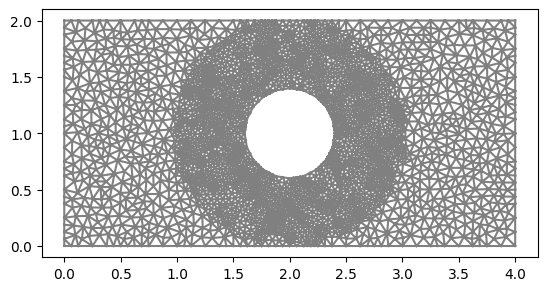

In [22]:
# Define rectangular domain
L = 4
H = 2

# Generate mesh with a hole
resolution = 32
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(0.5*L,0.5*H),0.4), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 1
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(0.5*L, 0.5*H)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

Define the Taylor-Hood mixed elements:

In [23]:
# Generate mixed finite element spaces (for velocity and pressure)
VE = VectorElement("CG", mesh.ufl_cell(), 2)
QE = FiniteElement("CG", mesh.ufl_cell(), 1)
WE = VE * QE

W = FunctionSpace(mesh, WE)
V = FunctionSpace(mesh, VE)
Q = FunctionSpace(mesh, QE)

# Define trial and test functions
w = Function(W)
(u, p) = (as_vector((w[0],w[1])), w[2])
(v, q) = TestFunctions(W)

Define the equal-order approximation space. $Q$ is the same as previously, but we need to redefine $V$ and $W$.


In [24]:
# Generate equal-order finite element spaces (for velocity and pressure)
VEL = VectorElement("CG", mesh.ufl_cell(), 1)
WEL = VEL * QE

WL = FunctionSpace(mesh, WEL)
VL = FunctionSpace(mesh, VEL)

# Define trial and test functions
wl = Function(WL)
(ul, pl) = (as_vector((wl[0],wl[1])), wl[2])
(vl, ql) = TestFunctions(WL)

We duplicate these, so that we later can study the effect of Brezzi-Pitkäranta stabilization:

In [36]:
# Generate equal-order finite element spaces (for velocity and pressure)
VES = VectorElement("CG", mesh.ufl_cell(), 1)
WES = VES * QE

WS = FunctionSpace(mesh, WES)
VS = FunctionSpace(mesh, VES)

# Define trial and test functions
ws = Function(WS)
(us, ps) = (as_vector((ws[0],ws[1])), ws[2])
(vs, qs) = TestFunctions(WS)

**Define boundary conditions**

In [26]:
# Inflow and outflow conditions
XMIN = 0.0; XMAX = L
YMIN = 0.0; YMAX = H

# For Taylor-Hood
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element())

# For equal-order approx
uinl = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = VL.ufl_element())

# Inflow boundary (ib), outflow boundary (ob) and wall boundary (wb)
ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element())
wb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, element = Q.ufl_element())

# **Results**

**Define and solve variational problem**

Taylor-Hood mixed elements:

In [27]:
h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h

f = Expression(("0.0","0.0"), element = V.ufl_element())

# Define variational problem on residual form: r(u,p;v,q) = 0
residual = ( - p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx +
            gamma*(ib*inner(u - uin, v) + wb*inner(u, v))*ds - inner(f, v)*dx )

# Solve algebraic system
solve(residual == 0, w)

Equal-order approximation spaces:

In [28]:
fl = Expression(("0.0","0.0"), element = VL.ufl_element())

# Define variational problem on residual form: r(u,p;v,q) = 0
residuall = ( - pl*div(vl)*dx + inner(grad(ul), grad(vl))*dx + div(ul)*ql*dx +
            gamma*(ib*inner(ul - uin, vl) + wb*inner(ul, vl))*ds - inner(fl, vl)*dx )

# Solve algebraic system
solve(residuall == 0, wl)

Equal-order approximation spaces with Brezzi-Pitkäranta stabilization, with $c=1$:

In [38]:
fs = Expression(("0.0","0.0"), element = VS.ufl_element())

# Define variational problem on residual form: r(u,p;v,q) = 0
residuals = ( - ps*div(vs)*dx + inner(grad(us), grad(vs))*dx + div(us)*qs*dx +
            gamma*(ib*inner(us - uin, vs) + wb*inner(us, vs))*ds - inner(fs, vs)*dx +
            h**2*inner(grad(ps), grad(qs))*dx)

# Solve algebraic system
solve(residuals == 0, ws)

**Visualize solution**

The resulting velocity and pressure fields when using the Taylor-Hood mixed elements are shown below.

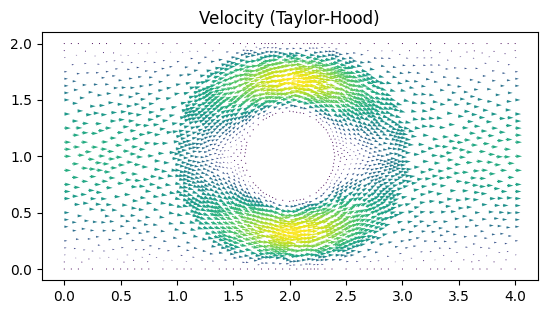

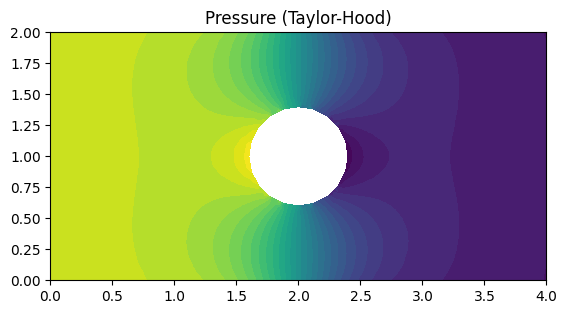

In [33]:
u1 = project(u, V)
p1 = project(p, Q)

plt.figure()
plot(u1, title="Velocity (Taylor-Hood)")

plt.figure()
plot(p1, title="Pressure (Taylor-Hood)")

plt.show()

The results for the equal-order approximation spaces are shown below. The velocity field is similar to that above, but the pressure field exhibits spurious oscillations, indicating that the solution is unstable.

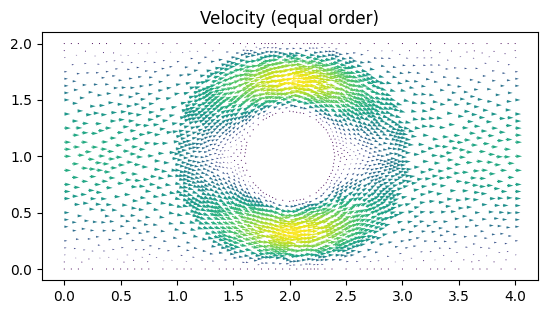

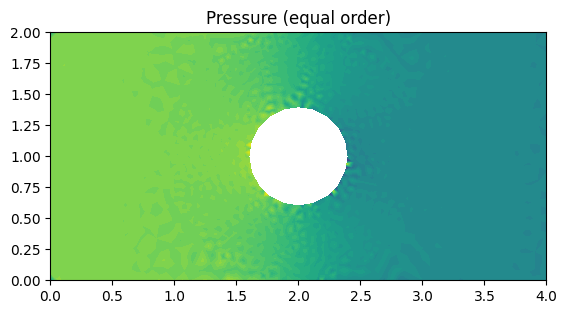

In [40]:
ul1 = project(ul, VL)
pl1 = project(pl, Q)

plt.figure()
plot(ul1, title="Velocity (equal order)")

plt.figure()
plot(pl1, title="Pressure (equal order)")

plt.show()

When introducing the stabilization term, we obtain the plots below. The pressure field no longer exhibits any oscillations, implying that the solution is now stable.

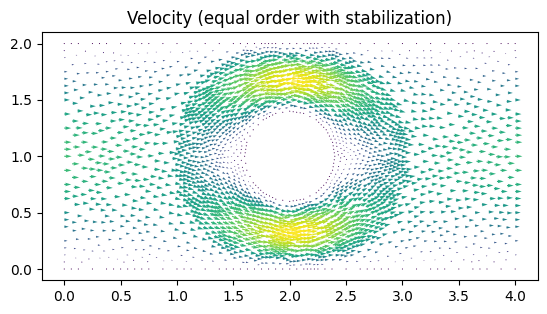

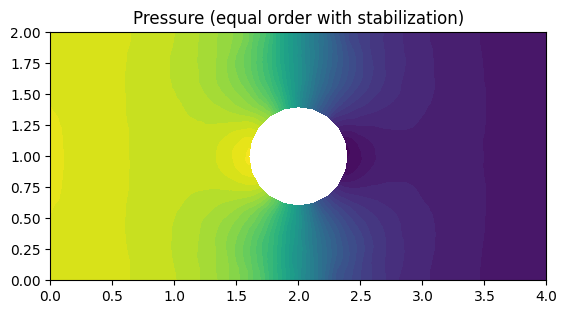

In [41]:
us1 = project(us, VS)
ps1 = project(ps, Q)

plt.figure()
plot(us1, title="Velocity (equal order with stabilization)")

plt.figure()
plot(ps1, title="Pressure (equal order with stabilization)")

plt.show()

# **Discussion**

A Taylor-Hood mixed finite element method was implemented in FEniCS to solve the Stokes equations in 2D. The method was tested for the model problem of flow past a circular obstacle. The solution behaved as expected, with a symmetric velocity and pressure, and pressure being higher at inflow than at outflow. Equal-order approximations of the pressure and velocity spaces were also implemented. This caused instabilities to manifest in the form of unphysical oscillations. These were successfully removed by implementing Brezzi-Pitkäranta stabilization.